# Basic Code

This section will tell you how to write a simple Python program to visualise the LIL as discussed in the preceding section.
The libary ``numpy`` will be used to do the heavy lifting, while ``matplotlib`` will be used for plotting:

In [139]:
import numpy as np 
from matplotlib import pyplot as plt

The following function computes the values of ``M`` paths for a standard normal distribution (mean zero and variance 1) and returns their values for the $$n$$ in ``ns``.

In [140]:
def generate_paths_basic(M,ns):
    """returns an array containing the values of M different paths at the values of n in ns"""
    rng = np.random.Generator(np.random.SFC64()) #nitialize RNG
    rand = rng.normal(size=(M,ns[-1])) #generate normal distributed data
    paths = np.cumsum(rand,axis=1) #calculate the partial sums from n=1 to n=ns[-1]
    return paths[:,ns-1] #only return the partial sums for those values of n in ns

We dont want to display the paths for all values of $$n$$. A logarithmic scale is a good idea:

In [141]:
X= np.logspace(1,6,base=10,num=1000) #create array of numbers between 10**1 and 10**6 that are equally  that are evenly spaced on a log scale for plotting of the iterated logarithm
ns = np.unique(np.round(X).astype(np.int64)) #create array of integers between 10**1 and 10**6 that are equally spaced on a log scale for plotting of the paths

Lets generate 80 paths

In [182]:
paths = generate_paths_basic(80,ns) 

and define the sequence $$l_n$$ to compare the paths with:

In [183]:
def iterlog(x):
    if x<=np.e:
        return 0.0
    else:
        return np.sqrt(2/x*np.log(np.log(x)))

iterlog = np.vectorize(iterlog) #to make sure the function is employed element-wise on arrays

Finally we can visualize the results:

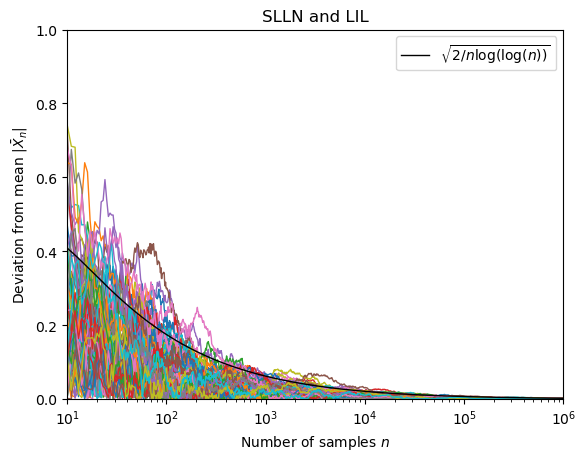

In [184]:
fig, ax = plt.subplots()

ax.plot(X,iterlog(X),color="black",lw =1,zorder=5,label=r"$\sqrt{2  /n \log ( \log (n))}$") #plot the iterated logarithm
for path in paths:
    ax.plot(ns,np.abs(path/ns),lw=1) #plot the path

ax.set_xlabel("Number of samples $n$")
ax.set_ylabel(r"Deviation from mean $|\bar{X}_n |$")
ax.set_xscale("log")
ax.set_xlim(ns[0],ns[-1])
ax.set_ylim(0,1)
plt.legend()
plt.title("SLLN and LIL")
plt.show()

# Optimized Code

This section tells you how to optimize the above code to deal with large numbers of samples.
In the process you will learn to write fast python code that leverages parallel computation with numba.
So lets get into it:
While the above code is very simple and executes relatively fast it has a big problem if we want to calculate the paths for even larger $$n$$:
It uses way too much ram.
This is because the function ``generate_paths_basic`` creates two huge arrays to store the random data and the partial sums in.
Of course we dont really need to generate all random data at once and store it in an array.
We also dont need to store all values of the paths.
Instead we only need to store the values of the paths that we want to display and we can generate random numbers as we are using them.
So lets optimize the code with the goal not to waste ram. While we are at it we can also add multi-threading.
To facilitate this we will be using the ``numba`` and the ``threading `` module.

In [127]:
import numpy as np 
from matplotlib import pyplot as plt 
import numba as nb 
import threading

The following function will be used to calculate the path differences between values of $$n$$ that we are interested in.

In [128]:
@nb.jit(nopython=True,fastmath=True,nogil=True)
def partial_sum(rng,n):
    """take an instance rng of the np.random.Generator() class and sum n normally distributed samples drawn from rng"""
    var=0
    for i in range(n):
        var+=rng.normal()
    return var

We are using the ``@nb.jit`` decorator to tell ``numba`` to treat the function to make it fast.
We pass an instance of the ``np.random.Generator()`` class to use it within the numba'd function (this only works because there is explicit support for this in numba).
This function has the advantage of not saving intermediate results and not creating large arrays (unlike using numpy would).
The usage of numba is critical, because the same code using vanilla python would run very slow and would be restricted from multi-threading by the python GIL.
We can use the ``partial_sum`` function to define a function that calculates the values of the paths at those $$n$$ in ``ns``:

In [129]:
@nb.jit(nopython=True,fastmath=True,nogil=True)
def generate_paths(paths,rng,ns,diffs):
    """takes an array paths and writes the relevant path values in it for paths.shape[0] different paths. Uses random samples from rng."""
    for j in range(paths.shape[0]):
        paths[j,0]=partial_sum(rng,ns[0])
        for ind,val in enumerate(diffs):
            paths[j,ind+1] = partial_sum(rng,val)+paths[j,ind]

and use it to do multi-threading:

In [130]:
def generate_paths_mt(M,threadnr,ns):
    """generate M paths (M is expected to be an integer multiple of threadnr) using threadnr different threads returning an array containing the values of the paths for those n in ns"""
    paths = np.empty(shape=(M,len(ns))) #array to save the values of the paths
    diffs = np.diff(ns) #array of differences in ns i.e. diffs[i] = ns[i+1]-ns[i]
    chunk_len = paths.shape[0]//threadnr #number of paths each thread calculates 
    chunks = [paths[i*chunk_len:(i+1)*chunk_len,:] for i in range(threadnr)] #one slice of the paths array for each thread to execute generate_paths on
    rngs = [np.random.Generator(np.random.SFC64()) for i in range(threadnr)] # one rng for each thread
    threads = [threading.Thread(target=generate_paths,args=([chunks[i],rngs[i],ns,diffs])) for i in range(threadnr)] #create the threads
    for thread in threads:
        thread.start()#start the thread
    for thread in threads:
        thread.join()#wait for the thread to finish
    return paths

There are two things worthy of notice here: Firstly the RNG that we are using is not thread-safe, therefore every thread must have their own RNG.
Secondly this form of multi-threading only speeds up computation because we call functions that haven been numba'd with the ``nogil=True``option circumventing the Python GIL.

Lets use this function to generate 80 paths with a large number of samples:

In [186]:
X= np.logspace(1,8,base=10,num=1000) #create array of equally spaced numbers on log scale for plotting of the iterated logarithm
ns = np.unique(np.round(X).astype(np.int64)) #create array of equally spaced integers on log scale for plotting of the paths

In [187]:
paths = generate_paths_mt(80,8,ns)

To visualise the data we proceed as before (the function ``iterlog`` is defined as in the preceding section).
The only changes are to add a 10-th root scale for better visibility of the data and to add some fancy ticks and tick labels.

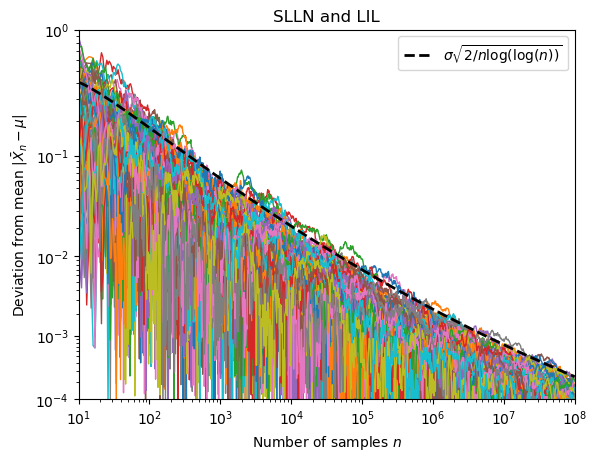

In [189]:
fig, ax = plt.subplots()

ax.plot(X,iterlog(X),color="black",lw =2,ls="--",zorder=5,label=r"$ \sigma \sqrt{2  /n \log ( \log (n))}$") #plot the iterated logarithm

for p in paths:
    ax.plot(ns,np.abs(p/ns),lw=1) #plot the path

ax.set_xlabel("Number of samples $n$")
ax.set_ylabel(r"Deviation from mean $|\bar{X}_n - \mu|$")
ax.set_xscale("log")
ax.set_xlim(ns[0],ns[-1])

def f(x):
    return x**(1/10)

def g(x):
    return x**10

ax.set_yscale("function", functions=(f, g))
ax.set_ylim(10**-4,10**0)
ax.set_yticks([ 10**(-1*i) for i in range(5)])
ax.set_yticks([(i+1)*10**(-1*j) for j in [1,2,3,4] for i in range(9) ],minor=True)
ax.set_yticklabels(["$10^{}$".format("{"+str(-1*i)+"}") for i in range(5)])

plt.legend()
plt.title("SLLN and LIL")
plt.show()

# Performance Analysis

Lets compare the performance of the two functions in a like for like scenario:

In [190]:
threadnr = 8
M = 10*threadnr #number of paths to calculate (expected to be integer multiple of the thread number)

In [191]:
X= np.logspace(1,6,base=10,num=1000) #create array of equally spaced numbers on log scale for plotting of the iterated logarithm
ns = np.unique(np.round(X).astype(np.int64)) #create array of equally spaced integers on log scale for plotting of the paths

First up a single thread vs single thread test:

In [199]:
%timeit paths = generate_paths_mt(M,1,ns) #using 1 thread to compare

723 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [198]:
%timeit paths = generate_paths_basic(M,ns)

1.67 s ± 54.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The optimized code is more than two times faster than the basic code!
Now lets use the maximum of 8 threads on my 4C/8T system:

In [204]:
%timeit paths = generate_paths_mt(M,8,ns) #using all 8 available threads (4C/8T)

191 ms ± 8.81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As expected almost four times faster than with 1 thread! 
We can also test with 4 threads (so no hyperthreading is in use):

In [208]:
%timeit paths = generate_paths_mt(M,4,ns) #using 4 available threads (one per core) (4C/8T)

220 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Around 15 percent slower than with hyperthreading.